In [1]:
from __future__ import print_function

import os
import pandas as pd
#import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import time
import pdb
import pickle
import random
import datetime 

import seaborn as sns 

import prim

import warnings; warnings.simplefilter('ignore')

In [2]:
%matplotlib notebook

# Data loading

In [3]:
data17_tg=pd.read_excel('EMIVASA_validationOutput_update2020_summer.xlsx',sheet_name='sH2O users') # 2017 data - treatment group summer
data17_cg=pd.read_excel('EMIVASA_validationOutput_update2020_summer.xlsx',sheet_name='Control group') # 2017 data - control group summer
data_tg_hour = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_Horaria',converters={'ENTORN': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group hourly frequency
data_tg_day = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_Diaria', converters={'ENTORN': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group daily frequency
data_tg_visual = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_visual',converters={'ENTORNO': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group visual reading

data19=pd.read_excel("Datos consumo hasta febrero 2019.xls") # 2019 data

In [4]:
# Merging user ID
data_tg_hour.keys()
data_tg_hour['User_ID']='AGM' + (data_tg_hour.NIA.astype(str))
data_tg_hour['User_ID']=data_tg_hour.User_ID.str.cat(data_tg_hour.SUBNIA.astype(str))
data_tg_day['User_ID']='AGM' + (data_tg_day.NIA.astype(str))
data_tg_day['User_ID']=data_tg_day.User_ID.str.cat(data_tg_day.SUBNIA.astype(str))
data_tg_visual['User_ID']='AGM' + (data_tg_visual.NIA.astype(str))
data_tg_visual['User_ID']=data_tg_visual.User_ID.str.cat(data_tg_visual.SUBNIA.astype(str))

# Data processing

In [5]:
# Finding user ID of SmartH2O users

# Treatment/control group ID in 2017 dataset
userID17_tg = data17_tg.User_ID
userID17_cg = data17_cg.User_ID

# Treatment/control group ID in 2019 dataset
userID19 = np.unique(data19['ID'])
userID19_tg = np.isin(userID19, userID17_tg) # treatment group
userID19_cg = np.isin(userID19, userID17_cg) # control group

userID19_tg = userID19[userID19_tg==True]
userID19_cg = userID19[userID19_cg==True]

## Storing all data for treatment group (SmartH2O users)

In [6]:
# In the SmartH2O, the observation period was 1.06.2016 to 17.02.2017. 
# Summer peak: July - August
allData_tg = pd.DataFrame([])#(columns=['User_ID', 'avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819', 'avg_sp_17','avg_sp_18'])

# Evaluating water consumption difference in 2017-19
for currUser in userID19_tg:

    # ::: Finding user positions in the whole dataset
    currUserCondition = data19['ID']==currUser
    
    #print(data19[currUserCondition])
    #pdb.set_trace()

    # Start and end date for observation period:
    dateConditionStart17 = data19['FECHA']>=20170701
    dateConditionEnd18 = data19['FECHA']<=20170831
    dateConditionZero17= data19['FECHA']<20170701 # This is used to evaluate the number of days considered in the first reading
    
    dateConditionStart18 = data19['FECHA']>=20180701
    dateConditionEnd19 = data19['FECHA']<=20180831
    dateConditionZero18= data19['FECHA']<20180701 # This is used to evaluate the number of days considered in the first reading

    # ::: Evaluating average consumption
    tg_data1718 = data19[currUserCondition & dateConditionStart17 & dateConditionEnd18] # Observation period 17-18
    dateZero1718 = data19[currUserCondition & dateConditionZero17]
  
    tg_data1819 = data19[currUserCondition & dateConditionStart18 & dateConditionEnd19] # Observation period 18-19
    dateZero1819 = data19[currUserCondition & dateConditionZero18]
    
    # Number of days for each period
    #
    # Observation period 17-18
    if (tg_data1718.empty == False):
        startD = datetime.datetime.strptime(str(tg_data1718.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(tg_data1718.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1718['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1718.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1718 = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1718 = (endD-startD).days + startD.day

    #
    # Observation period 18-19
    if (tg_data1819.empty == False):
        startD = datetime.datetime.strptime(str(tg_data1819.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(tg_data1819.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1819['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1819.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1819 = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1819 = (endD-startD).days + startD.day
    #
       
    # Average consumption values
    tg_data1718_avg = sum(tg_data1718['CONSUMO'])/nDays1718
    tg_data1819_avg = sum(tg_data1819['CONSUMO'])/nDays1819
    
    # Data frequency for meter reading: hourly/daily/visual. Data about the metere reading frequency only refer to the period 2017-18
    freq=[]
    if (np.isin(currUser, np.unique(data_tg_hour['User_ID']))):
        freq = 'hourly readings'
    elif (np.isin(currUser, np.unique(data_tg_day['User_ID']))):
        freq = 'daily readings'
    elif (np.isin(currUser, np.unique(data_tg_visual['User_ID']))):
        freq = 'visual readings'
        print('done')
    else:
        freq = np.nan

    # Conditions for outlier removal
    emptyHouseCondition = tg_data1718['CONSUMO'].empty or tg_data1819['CONSUMO'].empty # Homes with no entries
    if emptyHouseCondition == False:
        zeroRedingsPercCondition = np.percentile(tg_data1718['CONSUMO'],90) == 0 or np.percentile(tg_data1819['CONSUMO'],90) == 0
        lowOutlierCondition = sum(tg_data1718['CONSUMO']) < 1.5 or sum(tg_data1819['CONSUMO']) < 1.5
        highOutlierCondition = tg_data1718_avg > 1 or tg_data1819_avg > 1
    else:
        zeroRedingsPercCondition = False
        lowOutlierCondition = False
        highOutlierCondition = False

    # All data to save           
    if emptyHouseCondition or zeroRedingsPercCondition or lowOutlierCondition or highOutlierCondition:
        continue
    else:
        tempDf = pd.DataFrame({"User_ID":currUser, 
                               "avg_baseline":data17_tg[data17_tg['User_ID']==currUser]['average_consumption_baseline'],
                               "avg_1617":data17_tg[data17_tg['User_ID']==currUser]['average_consumption_observation'],
                               "avg_1718":tg_data1718_avg,
                               "avg_1819":tg_data1819_avg,
                               "tg": 1,
                               "freq": freq
                              }) 
        allData_tg=allData_tg.append(tempDf,ignore_index=True)
    #allData_tg.to_csv('allData_tg.csv',index=False)
    

## Storing all data for control group

In [7]:
# In the SmartH2O, the observation period was 1.06.2016 to 17.02.2017. 
# Summer peak: July - August
allData_cg = pd.DataFrame([])#(columns=['User_ID', 'avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819', 'avg_sp_17','avg_sp_18'])

# Evaluating water consumption difference in 2017-19
for currUser in userID19_cg:

    # ::: Finding user positions in the whole dataset
    currUserCondition = data19['ID']==currUser
    
    #print(data19[currUserCondition])
    #pdb.set_trace()

    # Start and end date for observation period:
    dateConditionStart17 = data19['FECHA']>=20170701
    dateConditionEnd18 = data19['FECHA']<=20170831
    dateConditionZero17= data19['FECHA']<20170701 # This is used to evaluate the number of days considered in the first reading
    
    dateConditionStart18 = data19['FECHA']>=20180701
    dateConditionEnd19 = data19['FECHA']<=20180831
    dateConditionZero18= data19['FECHA']<20180701 # This is used to evaluate the number of days considered in the first reading

    # ::: Evaluating average consumption
    cg_data1718 = data19[currUserCondition & dateConditionStart17 & dateConditionEnd18] # Observation period 17-18
    dateZero1718 = data19[currUserCondition & dateConditionZero17]
  
    cg_data1819 = data19[currUserCondition & dateConditionStart18 & dateConditionEnd19] # Observation period 18-19
    dateZero1819 = data19[currUserCondition & dateConditionZero18]
    
    # Number of days for each period
    #
    # Observation period 17-18
    if (cg_data1718.empty == False):
        startD = datetime.datetime.strptime(str(cg_data1718.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(cg_data1718.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1718['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1718.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1718 = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1718 = (endD-startD).days + startD.day

    #
    # Observation period 18-19
    if (cg_data1819.empty == False):
        startD = datetime.datetime.strptime(str(cg_data1819.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(cg_data1819.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1819['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1819.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1819 = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1819 = (endD-startD).days + startD.day
    #
       
    # Average consumption values
    cg_data1718_avg = sum(cg_data1718['CONSUMO'])/nDays1718
    cg_data1819_avg = sum(cg_data1819['CONSUMO'])/nDays1819


    # Conditions for outlier removal
    emptyHouseCondition = cg_data1718['CONSUMO'].empty or cg_data1819['CONSUMO'].empty # Homes with no entries
    if emptyHouseCondition == False:
        zeroRedingsPercCondition = np.percentile(cg_data1718['CONSUMO'],90) == 0 or np.percentile(cg_data1819['CONSUMO'],90) == 0
        lowOutlierCondition = sum(cg_data1718['CONSUMO']) < 1.5 or sum(cg_data1819['CONSUMO']) < 1.5
        highOutlierCondition = cg_data1718_avg > 1 or cg_data1819_avg > 1
    else:
        zeroRedingsPercCondition = False
        lowOutlierCondition = False
        highOutlierCondition = False

    # All data to save           
    if emptyHouseCondition or zeroRedingsPercCondition or lowOutlierCondition or highOutlierCondition:
        continue
    else:
        tempDf = pd.DataFrame({"User_ID":currUser, 
                               "avg_baseline":data17_cg[data17_cg['User_ID']==currUser]['average_consumption_baseline'],
                               "avg_1617":data17_cg[data17_cg['User_ID']==currUser]['average_consumption_observation'],
                               "avg_1718":cg_data1718_avg,
                               "avg_1819":cg_data1819_avg,
                               "cg": 1,
                              }) 
        allData_cg=allData_cg.append(tempDf,ignore_index=True)
    #allData_cg.to_csv('allData_cg.csv',index=False)
    

## Overall water consumption change

In [8]:
# Deleting outliers from CG
allData_cgTemp = allData_cg[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819']]
allData_cgTemp['avg_baseline'] = allData_cgTemp['avg_baseline'].astype(float)
allData_cgTemp['avg_1617'] = allData_cgTemp['avg_1617'].astype(float)
allData_cgTemp['avg_1718'] = allData_cgTemp['avg_1718'].astype(float)
allData_cgTemp['avg_1819'] = allData_cgTemp['avg_1819'].astype(float)
toKeep1 = (allData_cgTemp >= 0).all(1)
toKeep2 = (allData_cgTemp <= 1).all(1)

allData_cg = allData_cg[toKeep1 & toKeep2]

# Deleting outliers from TG
allData_tgTemp = allData_tg[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819']]
allData_tgTemp['avg_baseline'] = allData_tgTemp['avg_baseline'].astype(float)
allData_tgTemp['avg_1617'] = allData_tgTemp['avg_1617'].astype(float)
allData_tgTemp['avg_1718'] = allData_tgTemp['avg_1718'].astype(float)
allData_tgTemp['avg_1819'] = allData_tgTemp['avg_1819'].astype(float)

toKeep1 = (allData_tgTemp >= 0).all(1)
toKeep2 = (allData_tgTemp <= 1).all(1)

allData_tg = allData_tg[toKeep1 & toKeep2]

#::: SmartH2O treatment group
print(':: Treatment Group:')
# % change wrt baseline
avg_percC_tg=[]
avg_percC_tg.append(np.mean(np.divide((allData_tg['avg_1617'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
avg_percC_tg.append(np.mean(np.divide((allData_tg['avg_1718'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
avg_percC_tg.append(np.mean(np.divide((allData_tg['avg_1819'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
strToPrint = "Average [%] change: {}".format(avg_percC_tg)
print(strToPrint)
m_percC_tg=[]
m_percC_tg.append(np.median(np.divide((allData_tg['avg_1617'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
m_percC_tg.append(np.median(np.divide((allData_tg['avg_1718'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
m_percC_tg.append(np.median(np.divide((allData_tg['avg_1819'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
strToPrint = "Median [%] change: {}".format(m_percC_tg)
print(strToPrint)
# Tot vol change wrt baseline
avg_volC_tg = []
avg_volC_tg.append(((np.sum(allData_tg['avg_1617']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
avg_volC_tg.append(((np.sum(allData_tg['avg_1718']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
avg_volC_tg.append(((np.sum(allData_tg['avg_1819']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
strToPrint = "Tot vol change [%]: {}".format(avg_volC_tg)
print(strToPrint)
# Per-capita vol change wrt baseline
avg_volC_pc_tg = []
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1617']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1617'])*100)
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1718']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1718'])*100)
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1819']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1819'])*100)
strToPrint = "Per-capita vol change [cm]: {}".format(avg_volC_pc_tg)
print(strToPrint)

#::: SmartH2O control group
print(':: Control Group:')
# % change wrt baseline
avg_percC_cg=[]
avg_percC_cg.append(np.mean(np.divide((allData_cg['avg_1617'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
avg_percC_cg.append(np.mean(np.divide((allData_cg['avg_1718'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
avg_percC_cg.append(np.mean(np.divide((allData_cg['avg_1819'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
strToPrint = "Average [%] change: {}".format(avg_percC_cg)
print(strToPrint)
m_percC_cg=[]
m_percC_cg.append(np.median(np.divide((allData_cg['avg_1617'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
m_percC_cg.append(np.median(np.divide((allData_cg['avg_1718'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
m_percC_cg.append(np.median(np.divide((allData_cg['avg_1819'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
strToPrint = "Median [%] change: {}".format(m_percC_cg)
print(strToPrint)
# Vol change wrt baseline
avg_volC_cg = []
avg_volC_cg.append((np.sum(allData_cg['avg_1617']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
avg_volC_cg.append((np.sum(allData_cg['avg_1718']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
avg_volC_cg.append((np.sum(allData_cg['avg_1819']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
strToPrint = "Tot vol change [%]: {}".format(avg_volC_cg)
print(strToPrint)
# Per-capita vol change wrt baseline
avg_volC_pc_cg = []
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1617']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1617'])*100)
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1718']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1718'])*100)
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1819']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1819'])*100)
strToPrint = "Per-capita vol change [cm]: {}".format(avg_volC_pc_cg)
print(strToPrint)

:: Treatment Group:
Average [%] change: [2.0474513697385364, 2.585111901100987, 3.0387419291379163]
Median [%] change: [2.2757856878193516, -4.627713463581032, -11.70801367609848]
Tot vol change [%]: [-3.4866234272659815, -5.356633562149801, -5.556708748452141]
Per-capita vol change [cm]: [-0.7525910879308525, -1.1562346104426893, -1.1994210357244464]
:: Control Group:
Average [%] change: [34.38897705345496, 46.051544016247846, 56.46156850803571]
Median [%] change: [17.672366411184587, 16.05332007811466, 19.66600790617675]
Tot vol change [%]: [9.755687904424523, 16.529993172859864, 14.4593928448317]
Per-capita vol change [cm]: [1.7469514265623776, 2.9600265442375617, 2.589244059975351]


## Results visualization

<IPython.core.display.Javascript object>


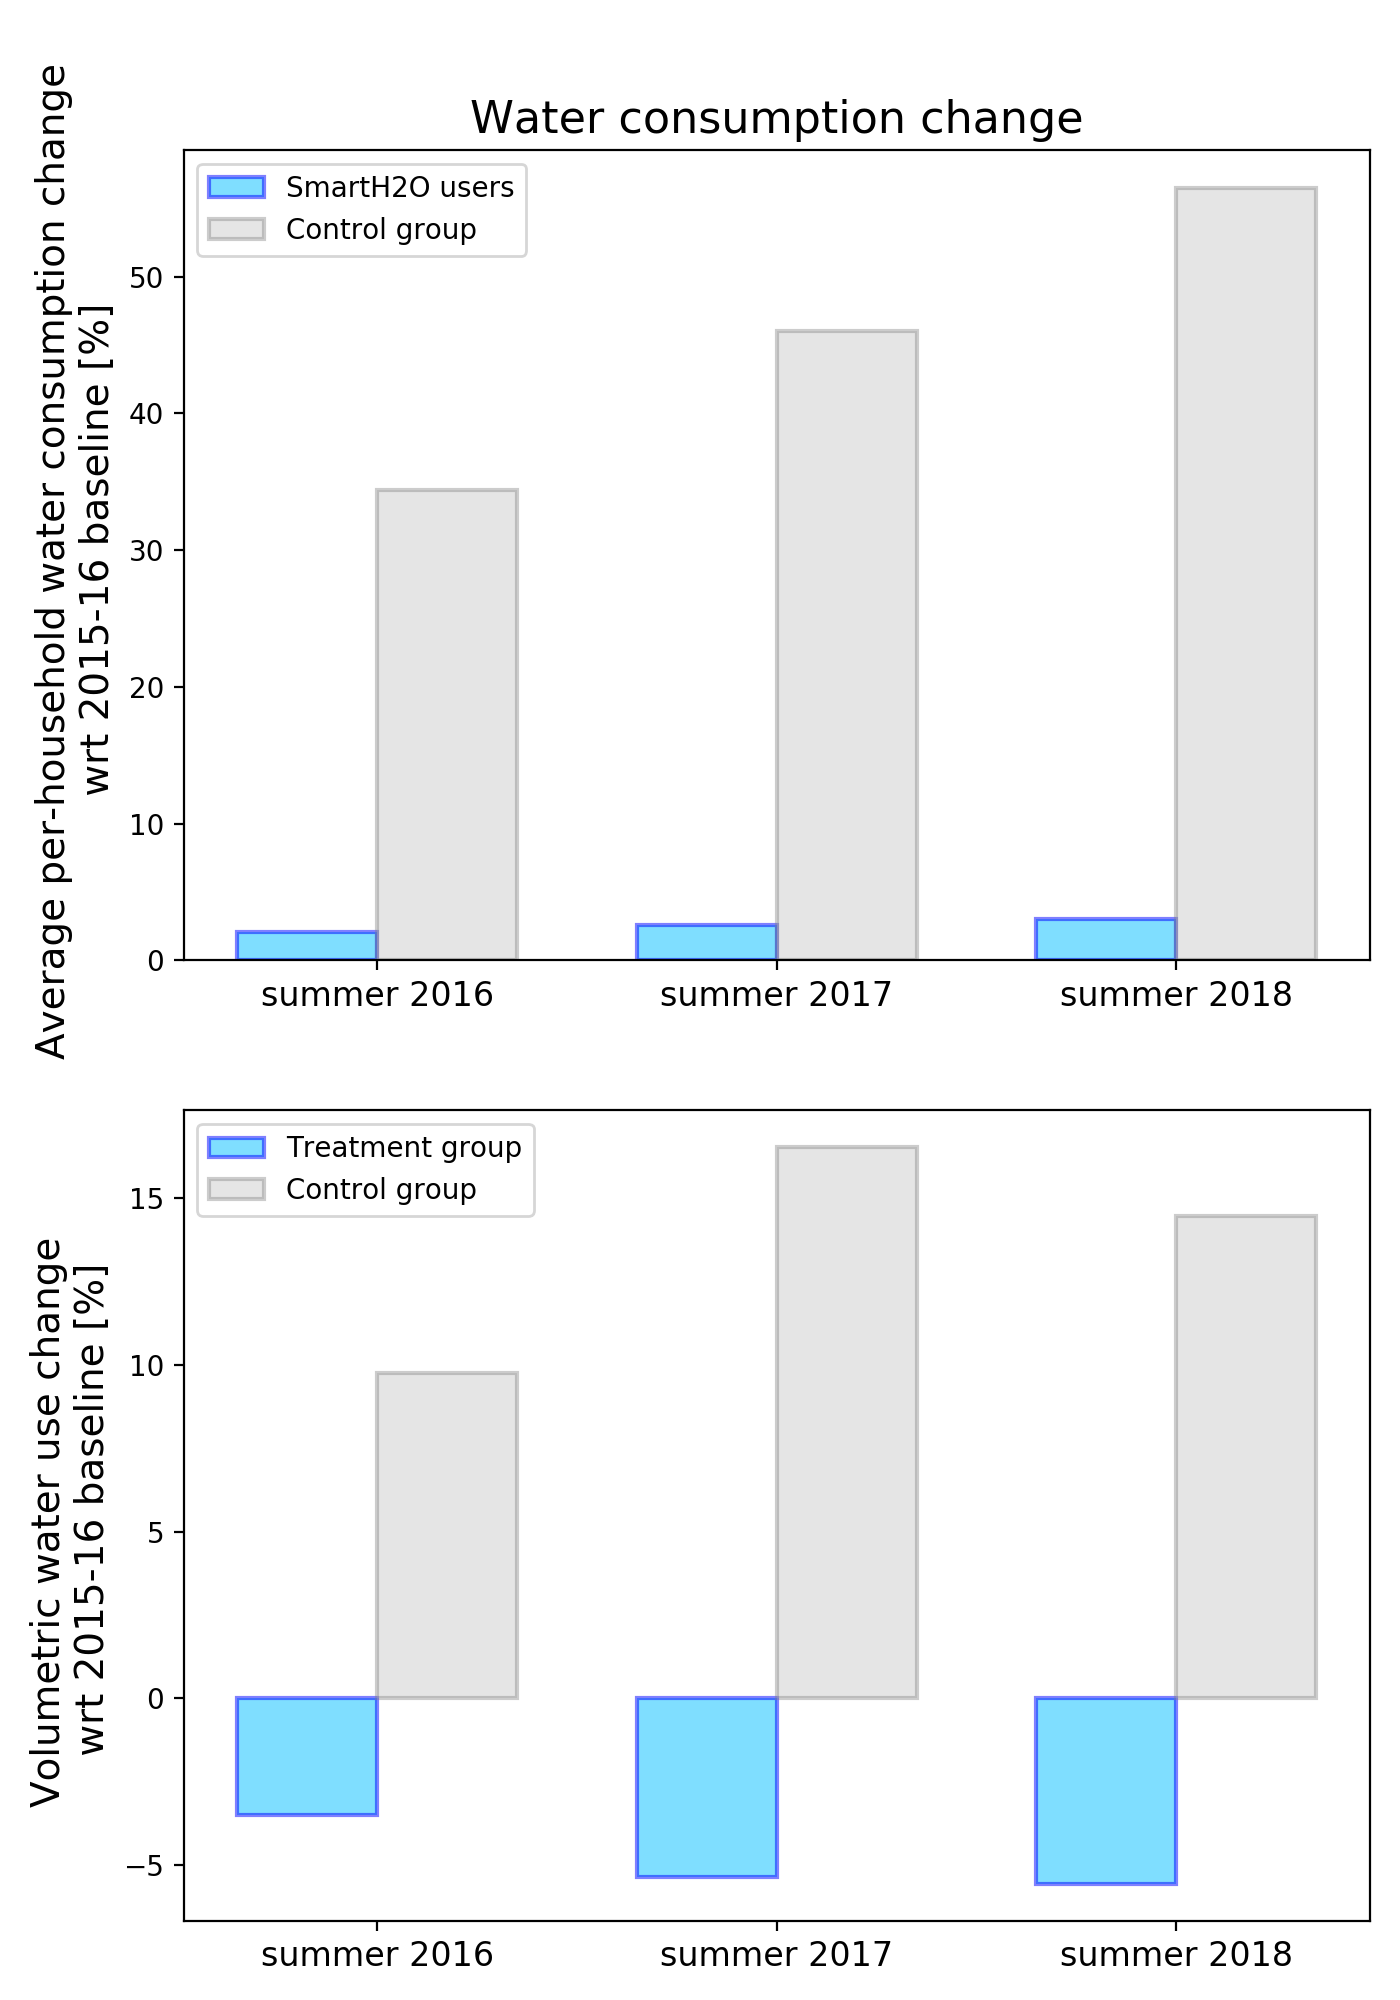

In [13]:
# ::: Water use change 
labels = ['summer 2016','summer 2017','summer 2018']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.rcParams['figure.figsize'] = [7, 10]
fig, ax = plt.subplots(2)

# Percentage water use change
rects1 = ax[0].bar(x - width/2, avg_percC_tg, width, label='SmartH2O users',color = 'deepskyblue', alpha=0.5, edgecolor = 'blue', linewidth=1.5)
rects2 = ax[0].bar(x + width/2, avg_percC_cg, width, label='Control group',color = 'silver', alpha=0.4, edgecolor = 'grey', linewidth=1.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Average per-household water consumption change \n wrt 2015-16 baseline [%]',fontsize=14)
ax[0].set_title('Water consumption change', fontsize=16)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].legend()
fig.tight_layout()
plt.show()

# Volumetric water use change
rects1 = ax[1].bar(x - width/2, avg_volC_tg, width, label='Treatment group', color = 'deepskyblue', alpha=0.5, edgecolor = 'blue', linewidth=1.5)
rects2 = ax[1].bar(x + width/2, avg_volC_cg, width, label='Control group',color = 'silver', alpha=0.4, edgecolor = 'grey', linewidth=1.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_ylabel('Volumetric water use change \n wrt 2015-16 baseline [%]',  fontsize=14)
#ax[1].set_title('Percentage water use change ')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].legend(loc='upper left')
fig.tight_layout()
plt.show()
#fig.savefig("sH2O_tgVScg_summer.pdf", bbox_inches='tight')
fig.savefig("PaperFigs/F2_summer.pdf", bbox_inches='tight')



<IPython.core.display.Javascript object>


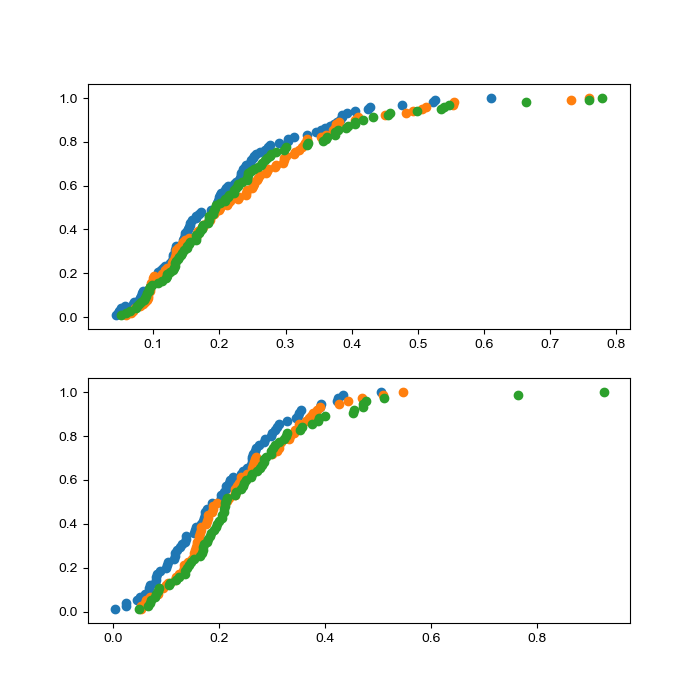

In [24]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

# Treatment group
x1617,y1617 = ecdf(allData_tg['avg_1617'])
x1718,y1718 = ecdf(allData_tg['avg_1718'])
x1819,y1819 = ecdf(allData_tg['avg_1819'])

plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots(2)
ax[0].scatter(x=x1617, y=y1617);
ax[0].scatter(x=x1718, y=y1718);
ax[0].scatter(x=x1819, y=y1819);

# Control group
x1617,y1617 = ecdf(allData_cg['avg_1617'])
x1718,y1718 = ecdf(allData_cg['avg_1718'])
x1819,y1819 = ecdf(allData_cg['avg_1819'])

ax[1].scatter(x=x1617, y=y1617);
ax[1].scatter(x=x1718, y=y1718);
ax[1].scatter(x=x1819, y=y1819);